<a href="https://colab.research.google.com/github/ikszn/V2G-Potential/blob/main/V2GPotentialv9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


V2G Potential Analysis
================================================================

This notebook provides a comprehensive analysis of Vehicle-to-Grid potential using
real-world EV charging data with proper economic modeling and optimization.

Author: Ikram Ahmed
Date: 08/09/2025

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ---- Enhanced Configuration ----
PEAK_HOUR = 17
RESERVE_PEAK = 40
BATTERY_KWH = 24
DISCHARGE_CAP = 2
PER_CAR_KW = 3.5
ETA_ROUNDTRIP = 0.90
RESERVE_EOD = 30
THETA_SOC = 0.50
TAU_MIN_HOURS = 2.0

# NEW: Additional analysis parameters
DEGRADATION_COST_PER_KWH = 0.05  # £/kWh battery degradation
GRID_EXPORT_LIMIT_KW = 1000      # Example grid constraint
PEAK_HOURS_RANGE = [16, 17, 18, 19]  # Extended peak period

# ===============================================
# 1. STREAMLINED EDA INTEGRATION
# ===============================================


In [ ]:
def run_essential_eda_integration(sessions_df):
    """Essential EDA integrated with enhanced analysis"""

    print("🔍 ESSENTIAL EDA METRICS")
    print("-" * 40)

    # Critical behavioral metrics (replaces X% placeholders)
    peak_sessions_pct = sessions_df['start_time'].dt.hour.isin(PEAK_HOURS_RANGE).mean() * 100
    v2g_viable_pct = (sessions_df['duration_h'] >= 2).mean() * 100
    avg_departure_soc = sessions_df['soc_end'].mean()
    avg_arrival_soc = sessions_df['soc_start'].mean()

    print(f"Peak hour overlap: {peak_sessions_pct:.1f}% of sessions")
    print(f"V2G viable duration: {v2g_viable_pct:.1f}% of sessions")
    print(f"Average departure SoC: {avg_departure_soc:.1f}%")
    print(f"Average arrival SoC: {avg_arrival_soc:.1f}%")

    # Energy headroom analysis
    reserve_levels = [40, 60, 80]
    energy_headroom = {}

    for reserve in reserve_levels:
        headroom_pct = np.maximum(0, sessions_df['soc_end'] - reserve)
        headroom_kwh = headroom_pct / 100 * BATTERY_KWH
        available_sessions = (headroom_pct > 0).mean() * 100

        energy_headroom[reserve] = {
            'mean_kwh': headroom_kwh.mean(),
            'available_sessions_pct': available_sessions
        }

        print(f"Energy above {reserve}% reserve: {headroom_kwh.mean():.2f} kWh avg ({available_sessions:.1f}% sessions)")

    # User segmentation (simple but effective)
    user_profiles = sessions_df.groupby('vehicle_id').agg({
        'duration_h': ['count', 'mean'],
        'start_time': lambda x: x.dt.hour.mean()
    }).round(2)

    user_profiles.columns = ['session_count', 'avg_duration', 'avg_start_hour']

    high_frequency = user_profiles['session_count'] > user_profiles['session_count'].median()
    peak_time_users = user_profiles['avg_start_hour'].between(16, 19)

    user_profiles['user_type'] = 'Occasional'
    user_profiles.loc[high_frequency & peak_time_users, 'user_type'] = 'Regular Commuter'
    user_profiles.loc[high_frequency & ~peak_time_users, 'user_type'] = 'Flexible User'

    user_type_stats = user_profiles['user_type'].value_counts()
    user_type_pct = (user_type_stats / len(user_profiles) * 100).round(1)

    print(f"User segments: Regular Commuters {user_type_pct.get('Regular Commuter', 0):.1f}%, "
          f"Flexible {user_type_pct.get('Flexible User', 0):.1f}%, "
          f"Occasional {user_type_pct.get('Occasional', 0):.1f}%")

    return {
        'peak_overlap_pct': peak_sessions_pct,
        'v2g_viable_pct': v2g_viable_pct,
        'avg_departure_soc': avg_departure_soc,
        'energy_headroom': energy_headroom,
        'user_segments': user_type_pct.to_dict()
    }

# ===============================================
# 1. ENHANCED DATA PREPROCESSING (Your Original + Improvements)
# ===============================================


In [ ]:
def load_and_enhance_ev_data(filepath):
    """Enhanced version of your original data loading with additional validation"""
    print("Loading and enhancing EV data...")

    # Check if file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Data file not found: {filepath}")

    try:
        # Your original preprocessing
        raw_df = pd.read_csv(filepath)

        # Check if required columns exist
        required_columns = ['ParticipantID', 'BatteryChargeStartDate', 'BatteryChargeStopDate',
                          'Starting SoC (of 12)', 'Ending SoC (of 12)']

        missing_columns = [col for col in required_columns if col not in raw_df.columns]
        if missing_columns:
            print(f"Warning: Missing columns {missing_columns}. Available columns: {list(raw_df.columns)}")
            # Try to adapt to different column names
            column_mapping = {}
            for col in raw_df.columns:
                if 'participant' in col.lower() or 'id' in col.lower():
                    column_mapping['ParticipantID'] = col
                elif 'start' in col.lower() and 'date' in col.lower():
                    column_mapping['BatteryChargeStartDate'] = col
                elif 'stop' in col.lower() and 'date' in col.lower():
                    column_mapping['BatteryChargeStopDate'] = col
                elif 'starting' in col.lower() and 'soc' in col.lower():
                    column_mapping['Starting SoC (of 12)'] = col
                elif 'ending' in col.lower() and 'soc' in col.lower():
                    column_mapping['Ending SoC (of 12)'] = col

            # Rename columns based on mapping
            raw_df = raw_df.rename(columns=column_mapping)

        raw_df = raw_df.rename(columns={
            'ParticipantID': 'vehicle_id',
            'BatteryChargeStartDate': 'start_time',
            'BatteryChargeStopDate': 'end_time',
            'Starting SoC (of 12)': 'soc_start_raw',
            'Ending SoC (of 12)': 'soc_end_raw'
        })

        raw_df = raw_df.dropna(subset=['start_time', 'end_time', 'vehicle_id'])
        raw_df['start_time'] = pd.to_datetime(raw_df['start_time'])
        raw_df['end_time'] = pd.to_datetime(raw_df['end_time'])
        raw_df['soc_start'] = (raw_df['soc_start_raw'] / 12) * 100
        raw_df['soc_end'] = (raw_df['soc_end_raw'] / 12) * 100

        # NEW: Enhanced data quality checks
        initial_count = len(raw_df)
        raw_df = raw_df[raw_df['end_time'] > raw_df['start_time']]
        raw_df = raw_df[
            raw_df['soc_start'].between(0, 100) &
            raw_df['soc_end'].between(0, 100)
        ]

        # NEW: Duration-based filtering and outlier detection
        raw_df['duration_h'] = (raw_df['end_time'] - raw_df['start_time']).dt.total_seconds() / 3600
        raw_df = raw_df[(raw_df['duration_h'] >= 0.1) & (raw_df['duration_h'] <= 48)]

        # NEW: Energy consumption analysis
        raw_df['energy_added_kwh'] = ((raw_df['soc_end'] - raw_df['soc_start']) / 100) * BATTERY_KWH
        raw_df['avg_charge_rate_kw'] = raw_df['energy_added_kwh'] / raw_df['duration_h']

        print(f"Enhanced dataset: {len(raw_df)} sessions ({100*len(raw_df)/initial_count:.1f}% retained)")
        return raw_df

    except Exception as e:
        print(f"Error loading data: {e}")
        # Create sample data for testing
        print("Creating sample data for testing...")
        return create_sample_data()

def create_sample_data():
    """Create sample data for testing when real data is not available"""
    np.random.seed(42)
    n_sessions = 1000

    # Generate sample EV charging sessions
    start_times = pd.date_range(start='2024-01-01', end='2024-12-31', freq='1H')
    sample_starts = np.random.choice(start_times, n_sessions)

    data = []
    for i, start_time in enumerate(sample_starts):
        duration = np.random.exponential(4) + 0.5  # Hours
        end_time = start_time + pd.Timedelta(hours=duration)
        soc_start = np.random.uniform(10, 80)
        soc_end = min(100, soc_start + np.random.uniform(10, 50))

        data.append({
            'vehicle_id': f'EV_{i % 50}',  # 50 unique vehicles
            'start_time': start_time,
            'end_time': end_time,
            'soc_start': soc_start,
            'soc_end': soc_end,
            'duration_h': duration,
            'energy_added_kwh': ((soc_end - soc_start) / 100) * BATTERY_KWH,
            'avg_charge_rate_kw': ((soc_end - soc_start) / 100) * BATTERY_KWH / duration
        })

    return pd.DataFrame(data)

def expand_sessions_to_hourly_enhanced(df):
    """Enhanced version of your time series expansion with additional features"""
    print("Expanding to enhanced hourly time series...")

    records = []
    for _, row in df.iterrows():
        vehicle = row['vehicle_id']
        t_start = row['start_time']
        t_end = row['end_time']
        soc_start = row['soc_start']
        soc_end = row['soc_end']

        if pd.isna(t_start) or pd.isna(t_end) or t_end <= t_start:
            continue

        times = pd.date_range(start=t_start.floor('h'), end=t_end.ceil('h'), freq='1h')
        total_steps = len(times) - 1
        if total_steps <= 0:
            continue

        for i in range(total_steps + 1):
            ts = times[i]
            soc_interp = soc_start + i * (soc_end - soc_start) / total_steps

            # NEW: Additional time-based features
            remaining_hours = max(0, (t_end - ts).total_seconds() / 3600)
            session_progress = i / max(total_steps, 1)  # 0 to 1

            records.append({
                'vehicle_id': vehicle,
                'timestamp': ts,
                'soc_pct': round(soc_interp, 1),
                'plugged_in': 1,
                'remaining_plugged_h': remaining_hours,
                'session_start': t_start,
                'session_end': t_end,
                'session_progress': session_progress,  # NEW
                'hour': ts.hour,
                'dow': ts.dayofweek,
                'month': ts.month,
                'is_weekend': ts.dayofweek >= 5,  # NEW
                'is_peak_period': ts.hour in PEAK_HOURS_RANGE,  # NEW
            })

    df_hourly = pd.DataFrame(records)

    # NEW: Season classification
    df_hourly['season'] = df_hourly['month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    })

    print(f"Enhanced hourly dataset: {len(df_hourly)} records")
    return df_hourly


# ===============================================
# 2. ENHANCED PRICING WITH MULTIPLE TARIFF SCENARIOS
# ===============================================

In [ ]:
def get_enhanced_pricing_data(region_code="C"):
    """Enhanced pricing with fallback and multiple scenarios"""
    print(f"Fetching enhanced pricing data for region {region_code}...")

    try:
        url = f"https://agilerates.uk/api/agile_rates_region_{region_code}.json"
        r = requests.get(url, timeout=30)
        r.raise_for_status()
        payload = r.json()

        rates = pd.json_normalize(payload["rates"])
        price_30m = rates[[
            "deliveryStart",
            "agileRate.result.rate",
            "agileOutgoingRate.result.rate"
        ]].rename(columns={
            "deliveryStart": "timestamp_utc",
            "agileRate.result.rate": "import_p_per_kwh",
            "agileOutgoingRate.result.rate": "export_p_per_kwh"
        })

        price_30m["timestamp_utc"] = pd.to_datetime(price_30m["timestamp_utc"], utc=True)
        price_30m["timestamp_local"] = price_30m["timestamp_utc"].dt.tz_convert("Europe/London")
        price_30m["export_gbp_per_kwh"] = price_30m["export_p_per_kwh"] / 100.0

        # Aggregate to hourly
        price_hourly = (
            price_30m.set_index("timestamp_local")
            .groupby(pd.Grouper(freq="1H"))["export_gbp_per_kwh"]
            .mean().reset_index()
            .rename(columns={"timestamp_local": "ts_hour"})
        )

        print(f"Real pricing data loaded: {len(price_hourly)} records")
        return price_hourly, "real"

    except Exception as e:
        print(f"API failed, using enhanced fallback pricing: {e}")
        return create_enhanced_fallback_pricing(), "fallback"

def create_enhanced_fallback_pricing():
    """Enhanced fallback with realistic UK patterns"""
    # More sophisticated pricing model
    base_prices = {
        'overnight': 0.08,   # 00:00-06:00
        'morning': 0.12,     # 06:00-16:00
        'peak': 0.25,        # 16:00-20:00
        'evening': 0.15      # 20:00-24:00
    }

    profile_data = []
    for dow in range(7):
        weekend_factor = 0.85 if dow >= 5 else 1.0

        for hour in range(24):
            if hour < 6:
                price = base_prices['overnight']
            elif hour < 16:
                price = base_prices['morning']
            elif hour < 20:
                price = base_prices['peak']
            else:
                price = base_prices['evening']

            # NEW: Add seasonal variation
            seasonal_factor = 1.2 if hour in [17, 18] else 1.0  # Winter peak premium
            price = price * weekend_factor * seasonal_factor

            profile_data.append({
                'dow': dow, 'hour': hour, 'export_gbp_per_kwh': price
            })

    return pd.DataFrame(profile_data)

def create_pricing_profile_enhanced(price_data, data_type):
    """Enhanced pricing profile with statistical analysis"""
    if data_type == "real":
        tmp = price_data.copy()
        tmp['dow'] = tmp['ts_hour'].dt.dayofweek
        tmp['hour'] = tmp['ts_hour'].dt.hour

        profile = tmp.groupby(['dow', 'hour']).agg({
            'export_gbp_per_kwh': ['mean', 'std', 'min', 'max']
        }).round(4)

        # Flatten column names
        profile.columns = ['_'.join(col).strip() for col in profile.columns]
        profile = profile.reset_index()

        # Use mean for main analysis
        pricing_profile = profile[['dow', 'hour', 'export_gbp_per_kwh_mean']].copy()
        pricing_profile = pricing_profile.rename(columns={'export_gbp_per_kwh_mean': 'export_gbp_per_kwh'})

    else:
        pricing_profile = price_data.copy()

    print(f"Pricing profile created with enhanced statistics")
    return pricing_profile

# ===============================================
# 3. NEW ANALYTICAL LAYERS - BEHAVIORAL ANALYSIS
# ===============================================

In [ ]:
def analyze_user_behavior_patterns(sessions_df):
    """NEW: Advanced behavioral analysis and user segmentation"""
    print("Analyzing user behavior patterns...")

    # Calculate user-level metrics
    user_metrics = sessions_df.groupby('vehicle_id').agg({
        'duration_h': ['mean', 'std', 'count'],
        'soc_start': 'mean',
        'soc_end': 'mean',
        'energy_added_kwh': 'mean',
        'start_time': [lambda x: x.dt.hour.mode().iloc[0] if len(x) > 0 else 17],  # Most common start hour
    }).round(2)

    user_metrics.columns = ['avg_duration', 'duration_std', 'session_count',
                           'avg_start_soc', 'avg_end_soc', 'avg_energy_added', 'preferred_start_hour']
    user_metrics = user_metrics.reset_index()

    # NEW: User segmentation via clustering
    features_for_clustering = ['avg_duration', 'avg_start_soc', 'avg_end_soc', 'preferred_start_hour', 'session_count']
    X = user_metrics[features_for_clustering].fillna(user_metrics[features_for_clustering].mean())

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find optimal clusters
    n_clusters = min(4, len(user_metrics))  # Ensure we don't have more clusters than data points
    if n_clusters < 2:
        print("Not enough data for clustering analysis")
        user_metrics['behavior_cluster'] = 0
        cluster_analysis = pd.DataFrame()
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        user_metrics['behavior_cluster'] = kmeans.fit_predict(X_scaled)

        # Analyze clusters
        cluster_analysis = user_metrics.groupby('behavior_cluster').agg({
            'avg_duration': 'mean',
            'avg_start_soc': 'mean',
            'preferred_start_hour': 'mean',
            'session_count': 'mean',
            'vehicle_id': 'count'
        }).round(1)
        cluster_analysis = cluster_analysis.rename(columns={'vehicle_id': 'num_users'})

        print("User Behavior Clusters:")
        for i, row in cluster_analysis.iterrows():
            print(f"  Cluster {i}: {row['num_users']} users, {row['avg_duration']:.1f}h avg, "
                  f"start at {row['preferred_start_hour']:.0f}:00, {row['session_count']:.0f} sessions")

    return user_metrics, cluster_analysis

def analyze_temporal_patterns(df_hourly):
    """NEW: Deep temporal pattern analysis"""
    print("Analyzing temporal patterns...")

    temporal_analysis = {}

    # 1. Hourly availability patterns
    hourly_availability = df_hourly.groupby('hour').agg({
        'vehicle_id': 'nunique',
        'soc_pct': 'mean',
        'plugged_in': 'sum'
    }).rename(columns={'vehicle_id': 'unique_vehicles', 'plugged_in': 'total_plugged'})

    # 2. Day-of-week patterns
    dow_patterns = df_hourly.groupby('dow').agg({
        'vehicle_id': 'nunique',
        'soc_pct': 'mean',
        'plugged_in': 'mean'
    })

    # 3. Seasonal patterns
    seasonal_patterns = df_hourly.groupby('season').agg({
        'vehicle_id': 'nunique',
        'soc_pct': 'mean',
        'plugged_in': 'mean'
    })

    # 4. Weekend vs weekday
    weekend_comparison = df_hourly.groupby('is_weekend').agg({
        'vehicle_id': 'nunique',
        'soc_pct': 'mean',
        'plugged_in': 'mean'
    })

    temporal_analysis = {
        'hourly': hourly_availability,
        'dow': dow_patterns,
        'seasonal': seasonal_patterns,
        'weekend_vs_weekday': weekend_comparison
    }

    print("Temporal patterns analyzed")
    return temporal_analysis

# ===============================================
# 4. ENHANCED V2G CALCULATIONS WITH MULTIPLE REVENUE STREAMS
# ===============================================

In [ ]:
def calculate_enhanced_exportable_energy(soc_pct, reserve_soc, battery_kwh=BATTERY_KWH, discharge_cap=DISCHARGE_CAP):
    """Enhanced exportable energy with grid constraints"""
    if pd.isna(soc_pct) or soc_pct <= reserve_soc:
        return 0.0

    available = (soc_pct - reserve_soc)/100.0 * battery_kwh

    # Apply both battery and grid constraints
    exportable = min(max(available, 0.0), discharge_cap)

    return float(exportable)

def calculate_comprehensive_revenue(export_kwh, price_gbp_per_kwh, include_degradation=True):
    """NEW: Comprehensive revenue calculation with multiple cost factors"""
    if export_kwh <= 0:
        return {
            'gross_revenue': 0.0,
            'efficiency_loss_cost': 0.0,
            'degradation_cost': 0.0,
            'net_revenue': 0.0,
            'revenue_per_kwh': 0.0
        }

    # Gross revenue from energy export
    gross_revenue = export_kwh * price_gbp_per_kwh

    # Round-trip efficiency loss (cost of replacement energy)
    efficiency_loss_cost = export_kwh * (1 - ETA_ROUNDTRIP) * price_gbp_per_kwh

    # Battery degradation cost
    degradation_cost = export_kwh * DEGRADATION_COST_PER_KWH if include_degradation else 0.0

    # Net revenue
    net_revenue = gross_revenue - efficiency_loss_cost - degradation_cost

    return {
        'gross_revenue': gross_revenue,
        'efficiency_loss_cost': efficiency_loss_cost,
        'degradation_cost': degradation_cost,
        'net_revenue': net_revenue,
        'revenue_per_kwh': net_revenue / export_kwh if export_kwh > 0 else 0.0
    }

def add_enhanced_v2g_metrics(df_hourly):
    """Enhanced V2G readiness with multiple reserve scenarios"""
    print("Calculating enhanced V2G metrics...")

    df = df_hourly.copy()

    # Basic V2G readiness (your original)
    df['v2g_ready'] = (
        (df['plugged_in'] == 1) &
        (df['soc_pct'] >= 100 * THETA_SOC) &
        (df['remaining_plugged_h'] >= TAU_MIN_HOURS)
    )

    # NEW: Multiple reserve scenarios
    reserve_scenarios = [30, 35, 40, 45, 50]
    for reserve in reserve_scenarios:
        export_col = f'export_kwh_reserve_{reserve}'
        df[export_col] = df.apply(
            lambda row: calculate_enhanced_exportable_energy(row['soc_pct'], reserve)
            if row['plugged_in'] == 1 else 0.0, axis=1
        )

    # NEW: Peak period specific readiness
    df['peak_period_ready'] = (
        df['v2g_ready'] &
        df['is_peak_period']
    )

    # NEW: Weekend vs weekday readiness
    df['weekend_ready'] = df['v2g_ready'] & df['is_weekend']
    df['weekday_ready'] = df['v2g_ready'] & (~df['is_weekend'])

    print("Enhanced V2G metrics calculated")
    return df


# ===============================================
# 5. ENHANCED SCENARIO ANALYSIS WITH NEW DIMENSIONS
# ===============================================

In [ ]:
def scenario_1_enhanced_peak_analysis(df, pricing_profile):
    """Enhanced Scenario 1 with grid impact assessment"""
    print("Enhanced Scenario 1: Peak Availability + Grid Impact")

    # Merge pricing
    df_with_pricing = df.merge(pricing_profile, on=['dow', 'hour'], how='left')

    # Focus on peak hours (extended analysis)
    results = {}

    for peak_hour in PEAK_HOURS_RANGE:
        df_peak = df_with_pricing[df_with_pricing['hour'] == peak_hour].copy()

        # Calculate export and revenue
        df_peak['export_kwh'] = df_peak[f'export_kwh_reserve_{RESERVE_PEAK}']

        # Apply comprehensive revenue calculation
        revenue_breakdown = df_peak.apply(
            lambda row: calculate_comprehensive_revenue(row['export_kwh'], row['export_gbp_per_kwh']),
            axis=1, result_type='expand'
        )
        df_peak = pd.concat([df_peak, revenue_breakdown], axis=1)

        # Aggregate results
        hourly_result = {
            'hour': peak_hour,
            'total_export_kwh': df_peak['export_kwh'].sum(),
            'total_gross_revenue': df_peak['gross_revenue'].sum(),
            'total_net_revenue': df_peak['net_revenue'].sum(),
            'vehicles_available': (df_peak['export_kwh'] > 0).sum(),
            'avg_export_per_vehicle': df_peak[df_peak['export_kwh'] > 0]['export_kwh'].mean() if (df_peak['export_kwh'] > 0).sum() > 0 else 0,
            'peak_shaving_potential_mw': df_peak['export_kwh'].sum() / 1000,  # Assume 1-hour dispatch
        }

        results[f'hour_{peak_hour}'] = hourly_result

    # Overall peak period analysis
    df_all_peak = df_with_pricing[df_with_pricing['is_peak_period']].copy()
    df_all_peak['export_kwh'] = df_all_peak[f'export_kwh_reserve_{RESERVE_PEAK}']

    revenue_breakdown = df_all_peak.apply(
        lambda row: calculate_comprehensive_revenue(row['export_kwh'], row['export_gbp_per_kwh']),
        axis=1, result_type='expand'
    )
    df_all_peak = pd.concat([df_all_peak, revenue_breakdown], axis=1)

    results['peak_period_summary'] = {
        'total_export_kwh': df_all_peak['export_kwh'].sum(),
        'total_net_revenue': df_all_peak['net_revenue'].sum(),
        'avg_hourly_availability': df_all_peak.groupby('hour')['export_kwh'].sum().mean(),
        'grid_support_value': df_all_peak['export_kwh'].sum() * 0.5,  # £/kWh grid support value
    }

    print(f"Peak Analysis Summary:")
    for hour in PEAK_HOURS_RANGE:
        r = results[f'hour_{hour}']
        print(f"   {hour}:00 - {r['total_export_kwh']:.1f} kWh, £{r['total_net_revenue']:.2f}, {r['vehicles_available']} vehicles")

    return results

In [ ]:
def scenario_2_enhanced_end_of_day(df, pricing_profile):
    """Enhanced Scenario 2: End-of-Day Surplus Energy Export"""
    print("Enhanced Scenario 2: End-of-Day Surplus + Annual Projections")

    df_with_pricing = df.merge(pricing_profile, on=['dow', 'hour'], how='left')

    # Get last record per vehicle-day
    df_eod = (df_with_pricing.sort_values('timestamp')
              .groupby(['vehicle_id', df_with_pricing['timestamp'].dt.date])
              .tail(1)
              .copy())

    # Calculate export potential with enhanced revenue calculation
    df_eod['export_kwh'] = df_eod[f'export_kwh_reserve_{RESERVE_EOD}']

    revenue_breakdown = df_eod.apply(
        lambda row: calculate_comprehensive_revenue(row['export_kwh'], row['export_gbp_per_kwh']),
        axis=1, result_type='expand'
    )
    df_eod = pd.concat([df_eod, revenue_breakdown], axis=1)

    # Calculate enhanced metrics
    n_days = df_eod['timestamp'].dt.date.nunique()
    n_vehicles = df_eod['vehicle_id'].nunique()
    annual_factor = 365.25 / max(n_days, 1)

    # Enhanced results
    results = {
        'scenario': 'S2: End-of-Day Surplus',
        'total_export_kwh': df_eod['export_kwh'].sum(),
        'total_gross_revenue': df_eod['gross_revenue'].sum(),
        'total_net_revenue': df_eod['net_revenue'].sum(),
        'annual_net_revenue_per_vehicle': df_eod.groupby('vehicle_id')['net_revenue'].sum().mean() * annual_factor,
        'annual_gross_revenue_per_vehicle': df_eod.groupby('vehicle_id')['gross_revenue'].sum().mean() * annual_factor,
        'avg_export_per_vehicle_day': df_eod.groupby(['vehicle_id', df_eod['timestamp'].dt.date])['export_kwh'].sum().mean(),
        'participation_rate': (df_eod['export_kwh'] > 0).mean(),
        'weekend_vs_weekday': {
            'weekend_revenue': df_eod[df_eod['is_weekend']]['net_revenue'].sum(),
            'weekday_revenue': df_eod[~df_eod['is_weekend']]['net_revenue'].sum()
        },
        'seasonal_breakdown': df_eod.groupby('season')['net_revenue'].sum().to_dict(),
        'data_period_days': n_days,
        'unique_vehicles': n_vehicles
    }

    print(f"End-of-Day Analysis:")
    print(f"   Annual revenue per vehicle: £{results['annual_net_revenue_per_vehicle']:.2f}")
    print(f"   Fleet total (study period): {results['total_export_kwh']:.1f} kWh, £{results['total_net_revenue']:.2f}")
    print(f"   Participation rate: {results['participation_rate']*100:.1f}%")

    return results

In [ ]:
def scenario_3_enhanced_charging_alignment(df, sessions_df, pricing_profile):
    """Enhanced Scenario 3: Charging Behavior Alignment with Peak Needs"""
    print("Enhanced Scenario 3: Charging Alignment + Behavioral Optimization")

    # Classify sessions by timing relative to peak
    def align_label(start_hour):
        if start_hour < PEAK_HOUR:
            return "Before Peak"
        elif start_hour == PEAK_HOUR:
            return "During Peak"
        else:
            return "After Peak"

    # Enhanced: Get first session per vehicle-day AND analyze all sessions
    sessions_with_date = sessions_df.copy()
    sessions_with_date['date'] = sessions_with_date['start_time'].dt.date

    # First session alignment
    first_sessions = (sessions_with_date.sort_values('start_time')
                     .groupby(['vehicle_id', 'date'])
                     .first()
                     .reset_index())
    first_sessions['alignment'] = first_sessions['start_time'].dt.hour.apply(align_label)

    # Merge pricing and get peak hour export data
    df_with_pricing = df.merge(pricing_profile, on=['dow', 'hour'], how='left')
    df_peak = df_with_pricing[df_with_pricing['hour'] == PEAK_HOUR].copy()
    df_peak['export_kwh'] = df_peak[f'export_kwh_reserve_{RESERVE_PEAK}']

    revenue_breakdown = df_peak.apply(
        lambda row: calculate_comprehensive_revenue(row['export_kwh'], row['export_gbp_per_kwh']),
        axis=1, result_type='expand'
    )
    df_peak = pd.concat([df_peak, revenue_breakdown], axis=1)

    # Merge alignment data
    df_peak['date'] = df_peak['timestamp'].dt.date
    df_alignment = df_peak.merge(
        first_sessions[['vehicle_id', 'date', 'alignment']],
        on=['vehicle_id', 'date'], how='left'
    )

    # Enhanced alignment analysis
    alignment_metrics = df_alignment.groupby('alignment').agg({
        'export_kwh': ['mean', 'sum', 'count'],
        'net_revenue': ['mean', 'sum'],
        'soc_pct': 'mean'
    }).round(3)

    # Behavioral optimization potential
    before_peak_vehicles = df_alignment[df_alignment['alignment'] == 'Before Peak']

    optimization_potential = {
        'current_optimal_behavior_pct': len(before_peak_vehicles) / len(df_alignment) * 100 if len(df_alignment) > 0 else 0,
        'revenue_if_all_optimal': len(df_alignment) * before_peak_vehicles['net_revenue'].mean() if len(before_peak_vehicles) > 0 else 0,
        'current_total_revenue': df_alignment['net_revenue'].sum(),
        'avg_soc_by_alignment': df_alignment.groupby('alignment')['soc_pct'].mean().to_dict()
    }

    optimization_potential['optimization_uplift_gbp'] = optimization_potential['revenue_if_all_optimal'] - optimization_potential['current_total_revenue']

    results = {
        'scenario': 'S3: Charging Alignment',
        'alignment_metrics': alignment_metrics,
        'optimization_potential': optimization_potential,
        'total_vehicles_analyzed': len(df_alignment)
    }

    print(f"Charging Alignment Analysis:")
    print(f"   Optimal behavior (charge before peak): {optimization_potential['current_optimal_behavior_pct']:.1f}%")
    print(f"   Revenue optimization potential: £{optimization_potential['optimization_uplift_gbp']:.2f}")

    return results

In [ ]:
def scenario_4_grid_services_analysis(df, pricing_profile):
    """NEW Scenario 4: Multiple grid services revenue stacking"""
    print("NEW Scenario 4: Grid Services Revenue Stacking")

    df_services = df.merge(pricing_profile, on=['dow', 'hour'], how='left')

    # Calculate multiple revenue streams
    df_services['export_kwh'] = df_services[f'export_kwh_reserve_{RESERVE_PEAK}']

    # 1. Energy arbitrage
    revenue_breakdown = df_services.apply(
        lambda row: calculate_comprehensive_revenue(row['export_kwh'], row['export_gbp_per_kwh']),
        axis=1, result_type='expand'
    )
    df_services = pd.concat([df_services, revenue_breakdown], axis=1)

    # 2. NEW: Frequency response revenue (£/MW/h availability payment)
    frequency_response_rate = 8.0  # £/MW/h typical rate
    df_services['frequency_response_revenue'] = (
        df_services['export_kwh'] * frequency_response_rate / 1000  # Convert kW to MW
    )

    # 3. NEW: Capacity market revenue (£/kW/year)
    capacity_market_rate = 45.0  # £/kW/year
    df_services['capacity_market_revenue'] = (
        df_services['export_kwh'] * capacity_market_rate / (365 * 24)  # Daily share
    )

    # 4. NEW: Balancing services (peak hours only)
    balancing_rate = 50.0  # £/MWh
    df_services['balancing_revenue'] = np.where(
        df_services['is_peak_period'],
        df_services['export_kwh'] * balancing_rate / 1000,
        0
    )

    # Total stacked revenue
    df_services['total_stacked_revenue'] = (
        df_services['net_revenue'] +
        df_services['frequency_response_revenue'] +
        df_services['capacity_market_revenue'] +
        df_services['balancing_revenue']
    )

    # Aggregate results
    services_summary = {
        'energy_arbitrage': df_services['net_revenue'].sum(),
        'frequency_response': df_services['frequency_response_revenue'].sum(),
        'capacity_market': df_services['capacity_market_revenue'].sum(),
        'balancing_services': df_services['balancing_revenue'].sum(),
        'total_stacked': df_services['total_stacked_revenue'].sum(),
        'revenue_uplift_factor': df_services['total_stacked_revenue'].sum() / max(df_services['net_revenue'].sum(), 1)
    }

    print(f"Revenue Stacking Analysis:")
    print(f"   Energy arbitrage: £{services_summary['energy_arbitrage']:.2f}")
    print(f"   Frequency response: £{services_summary['frequency_response']:.2f}")
    print(f"   Capacity market: £{services_summary['capacity_market']:.2f}")
    print(f"   Balancing services: £{services_summary['balancing_services']:.2f}")
    print(f"   Total stacked: £{services_summary['total_stacked']:.2f}")
    print(f"   Revenue uplift: {services_summary['revenue_uplift_factor']:.1f}x")

    return services_summary, df_services

In [ ]:
def scenario_5_future_fleet_projections(df, pricing_profile):
    """NEW Scenario 5: Future EV fleet growth projections"""
    print("NEW Scenario 5: Future Fleet Growth Projections")

    df_future = df.merge(pricing_profile, on=['dow', 'hour'], how='left')

    # Base case (current fleet)
    current_vehicles = df_future['vehicle_id'].nunique()

    # Future scenarios
    growth_scenarios = {
        '2025': {'fleet_multiplier': 2, 'battery_kwh': 35, 'participation_rate': 0.3},
        '2030': {'fleet_multiplier': 5, 'battery_kwh': 50, 'participation_rate': 0.5},
        '2035': {'fleet_multiplier': 10, 'battery_kwh': 70, 'participation_rate': 0.7},
    }

    projection_results = {}

    for year, scenario in growth_scenarios.items():
        # Scale up the fleet
        df_scaled = pd.concat([df_future] * scenario['fleet_multiplier'], ignore_index=True)

        # Update vehicle IDs to avoid duplicates
        df_scaled['vehicle_id'] = df_scaled.index

        # Recalculate export potential with larger batteries
        df_scaled['export_kwh_future'] = df_scaled.apply(
            lambda row: calculate_enhanced_exportable_energy(
                row['soc_pct'], RESERVE_PEAK, scenario['battery_kwh']
            ) if row['plugged_in'] == 1 else 0.0, axis=1
        )

        # Apply participation rate
        df_scaled['export_kwh_future'] *= scenario['participation_rate']

        # Calculate revenue
        revenue_breakdown = df_scaled.apply(
            lambda row: calculate_comprehensive_revenue(row['export_kwh_future'], row['export_gbp_per_kwh']),
            axis=1, result_type='expand'
        )

        # Aggregate for peak hour
        peak_results = df_scaled[df_scaled['hour'] == PEAK_HOUR]

        projection_results[year] = {
            'fleet_size': scenario['fleet_multiplier'] * current_vehicles,
            'total_export_kwh': peak_results['export_kwh_future'].sum(),
            'total_revenue': revenue_breakdown[df_scaled['hour'] == PEAK_HOUR]['net_revenue'].sum(),
            'grid_support_mw': peak_results['export_kwh_future'].sum() / 1000,
            'participation_rate': scenario['participation_rate'] * 100
        }

    print(f"Future Fleet Projections (Peak Hour):")
    for year, results in projection_results.items():
        print(f"   {year}: {results['fleet_size']:,} vehicles, {results['total_export_kwh']:.0f} kWh, "
              f"£{results['total_revenue']:.0f}, {results['grid_support_mw']:.1f} MW")

    return projection_results

# ===============================================
# 6. ENHANCED SENSITIVITY ANALYSIS WITH MONTE CARLO
# ===============================================

In [ ]:
def enhanced_sensitivity_analysis(df, pricing_profile):
    """Enhanced sensitivity with Monte Carlo uncertainty analysis"""
    print("Enhanced Sensitivity Analysis with Monte Carlo")

    df_sens = df.merge(pricing_profile, on=['dow', 'hour'], how='left')
    df_peak = df_sens[df_sens['hour'] == PEAK_HOUR].copy()

    # Base case
    base_export = df_peak[f'export_kwh_reserve_{RESERVE_PEAK}'].sum()
    base_revenue = df_peak.apply(
        lambda row: calculate_comprehensive_revenue(
            calculate_enhanced_exportable_energy(row['soc_pct'], RESERVE_PEAK),
            row['export_gbp_per_kwh']
        )['net_revenue'], axis=1
    ).sum()

    # NEW: Monte Carlo uncertainty analysis
    n_simulations = 1000
    print(f"Running {n_simulations} Monte Carlo simulations...")

    monte_carlo_results = []

    for sim in range(n_simulations):
        # Random parameter variations
        random_participation = np.random.normal(0.5, 0.15)  # 50% ± 15%
        random_reserve = np.random.normal(40, 5)  # 40% ± 5%
        random_efficiency = np.random.normal(0.90, 0.02)  # 90% ± 2%
        random_degradation = np.random.normal(0.05, 0.01)  # £0.05 ± £0.01

        # Constrain to reasonable bounds
        random_participation = np.clip(random_participation, 0.1, 1.0)
        random_reserve = np.clip(random_reserve, 25, 55)
        random_efficiency = np.clip(random_efficiency, 0.8, 0.95)
        random_degradation = np.clip(random_degradation, 0.02, 0.1)

        # Calculate scenario result
        sim_export = df_peak.apply(
            lambda row: calculate_enhanced_exportable_energy(row['soc_pct'], random_reserve), axis=1
        ).sum() * random_participation

        sim_revenue = sim_export * df_peak['export_gbp_per_kwh'].mean() * random_efficiency - \
                     sim_export * random_degradation

        monte_carlo_results.append({
            'export_kwh': sim_export,
            'net_revenue': sim_revenue,
            'participation': random_participation,
            'reserve_soc': random_reserve,
            'efficiency': random_efficiency,
            'degradation_cost': random_degradation
        })

    mc_df = pd.DataFrame(monte_carlo_results)

    # Statistical summary
    mc_summary = {
        'mean_export': mc_df['export_kwh'].mean(),
        'p5_export': mc_df['export_kwh'].quantile(0.05),
        'p95_export': mc_df['export_kwh'].quantile(0.95),
        'mean_revenue': mc_df['net_revenue'].mean(),
        'p5_revenue': mc_df['net_revenue'].quantile(0.05),
        'p95_revenue': mc_df['net_revenue'].quantile(0.95),
        'revenue_std': mc_df['net_revenue'].std()
    }

    print(f"Monte Carlo Results:")
    print(f"   Export kWh: {mc_summary['mean_export']:.1f} (90% CI: {mc_summary['p5_export']:.1f} - {mc_summary['p95_export']:.1f})")
    print(f"   Revenue £: {mc_summary['mean_revenue']:.2f} (90% CI: {mc_summary['p5_revenue']:.2f} - {mc_summary['p95_revenue']:.2f})")

    return {}, mc_summary, mc_df

# ===============================================
# 7. COMPREHENSIVE VISUALIZATION SUITE
# ===============================================

In [ ]:
def create_v2g_dashboard(temporal_patterns, s1_results, s4_results, s5_results, mc_summary):
    """Create comprehensive V2G dashboard with all scenarios - FIXED VERSION"""
    print("Creating V2G comprehensive dashboard...")

    # Create output directory
    os.makedirs('figures/enhanced', exist_ok=True)

    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Enhanced V2G Potential Analysis - Comprehensive Dashboard', fontsize=16, fontweight='bold')

    # 1. Hourly availability patterns
    hourly_data = temporal_patterns['hourly']
    axes[0, 0].plot(hourly_data.index, hourly_data['unique_vehicles'], 'o-', linewidth=2, color='steelblue')
    axes[0, 0].set_title('Vehicle Availability by Hour')
    axes[0, 0].set_xlabel('Hour of Day')
    axes[0, 0].set_ylabel('Unique Vehicles')
    axes[0, 0].grid(alpha=0.3)
    axes[0, 0].axvspan(16, 19, alpha=0.2, color='red', label='Peak Period')
    axes[0, 0].legend()

    # 2. Peak hour comparison across hours
    peak_export = [s1_results[f'hour_{h}']['total_export_kwh'] for h in PEAK_HOURS_RANGE]
    axes[0, 1].bar(PEAK_HOURS_RANGE, peak_export, color='orange', alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Export Potential by Peak Hour')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel('Export Potential (kWh)')
    axes[0, 1].grid(axis='y', alpha=0.3)

    # 3. Revenue stacking comparison
    services = ['energy_arbitrage', 'frequency_response', 'capacity_market', 'balancing_services']
    service_values = [s4_results[0][service] for service in services]
    axes[0, 2].bar(range(len(services)), service_values, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
    axes[0, 2].set_title('Revenue Stacking Breakdown')
    axes[0, 2].set_ylabel('Revenue (£)')
    axes[0, 2].set_xticks(range(len(services)))
    axes[0, 2].set_xticklabels(['Energy', 'Frequency', 'Capacity', 'Balancing'], rotation=45)
    axes[0, 2].grid(axis='y', alpha=0.3)

    # 4. Seasonal patterns
    seasonal_data = temporal_patterns['seasonal']
    axes[1, 0].bar(seasonal_data.index, seasonal_data['vehicle_id'], color='forestgreen', alpha=0.7)
    axes[1, 0].set_title('Seasonal Availability Patterns')
    axes[1, 0].set_ylabel('Unique Vehicles')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # 5. Future fleet projections
    years = list(s5_results.keys())
    fleet_sizes = [s5_results[year]['fleet_size'] for year in years]
    export_potential = [s5_results[year]['total_export_kwh'] for year in years]

    ax5 = axes[1, 1]
    ax5_twin = ax5.twinx()

    x_pos = range(len(years))
    bars1 = ax5.bar([x - 0.2 for x in x_pos], fleet_sizes, width=0.4, alpha=0.6, color='blue', label='Fleet Size')
    bars2 = ax5_twin.bar([x + 0.2 for x in x_pos], export_potential, width=0.4, alpha=0.6, color='red', label='Export (kWh)')

    ax5.set_title('Future Fleet Growth Projections')
    ax5.set_ylabel('Fleet Size', color='blue')
    ax5_twin.set_ylabel('Export Potential (kWh)', color='red')
    ax5.set_xticks(x_pos)
    ax5.set_xticklabels(years)

    # 6. Weekend vs weekday comparison
    weekend_data = temporal_patterns['weekend_vs_weekday']
    categories = ['Weekday', 'Weekend']
    vehicles = weekend_data['vehicle_id'].values

    axes[1, 2].bar(categories, vehicles, color=['lightblue', 'lightcoral'], alpha=0.7, edgecolor='black')
    axes[1, 2].set_title('Weekday vs Weekend Availability')
    axes[1, 2].set_ylabel('Average Unique Vehicles')
    axes[1, 2].grid(axis='y', alpha=0.3)

    # 7. Monte Carlo uncertainty visualization
    revenue_values = [mc_summary['p5_revenue'], mc_summary['mean_revenue'], mc_summary['p95_revenue']]
    revenue_labels = ['P5', 'Mean', 'P95']
    axes[2, 0].bar(revenue_labels, revenue_values, alpha=0.7, color='purple', edgecolor='black')
    axes[2, 0].set_title('Revenue Uncertainty (Monte Carlo)')
    axes[2, 0].set_ylabel('Revenue (£)')
    axes[2, 0].grid(axis='y', alpha=0.3)

    # 8. Day-of-week patterns
    dow_data = temporal_patterns['dow']
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    axes[2, 1].plot(dow_names, dow_data['vehicle_id'].values, 'o-', linewidth=2, markersize=6, color='darkorange')
    axes[2, 1].set_title('Day-of-Week Availability Pattern')
    axes[2, 1].set_ylabel('Unique Vehicles')
    axes[2, 1].grid(alpha=0.3)
    axes[2, 1].tick_params(axis='x', rotation=45)

    # 9. Grid impact summary
    total_peak_support = sum(s1_results[f'hour_{h}']['peak_shaving_potential_mw'] for h in PEAK_HOURS_RANGE)
    grid_metrics = ['Current MW', 'Future 2030', 'With Services']
    grid_values = [total_peak_support, s5_results['2030']['grid_support_mw'], total_peak_support * 2.5]

    axes[2, 2].bar(grid_metrics, grid_values, color=['red', 'orange', 'green'], alpha=0.7, edgecolor='black')
    axes[2, 2].set_title('Grid Support Potential')
    axes[2, 2].set_ylabel('Peak Support (MW)')
    axes[2, 2].grid(axis='y', alpha=0.3)
    axes[2, 2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('figures/enhanced/comprehensive_v2g_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Enhanced visualizations created and saved!")

# ===============================================
# 8. MAIN EXECUTION WITH ENHANCED WORKFLOW
# ===============================================

Starting Enhanced V2G Potential Analysis...
Loading and enhancing EV data...
Enhanced dataset: 74999 sessions (97.8% retained)
Expanding to enhanced hourly time series...
Enhanced hourly dataset: 380239 records
Fetching enhanced pricing data for region C...
Real pricing data loaded: 48 records
Pricing profile created with enhanced statistics
Calculating enhanced V2G metrics...
Enhanced V2G metrics calculated
Analyzing user behavior patterns...
User Behavior Clusters:
  Cluster 0: 61.0 users, 2.9h avg, start at 17:00, 471 sessions
  Cluster 1: 38.0 users, 3.2h avg, start at 6:00, 316 sessions
  Cluster 2: 71.0 users, 4.1h avg, start at 18:00, 247 sessions
  Cluster 3: 45.0 users, 2.6h avg, start at 15:00, 372 sessions
Analyzing temporal patterns...
Temporal patterns analyzed

======================================== SCENARIO ANALYSIS ========================================
⚡ Enhanced Scenario 1: Peak Availability + Grid Impact
📊 Peak Analysis Summary:
   16:00 - 29486.6 kWh, £566.55, 1

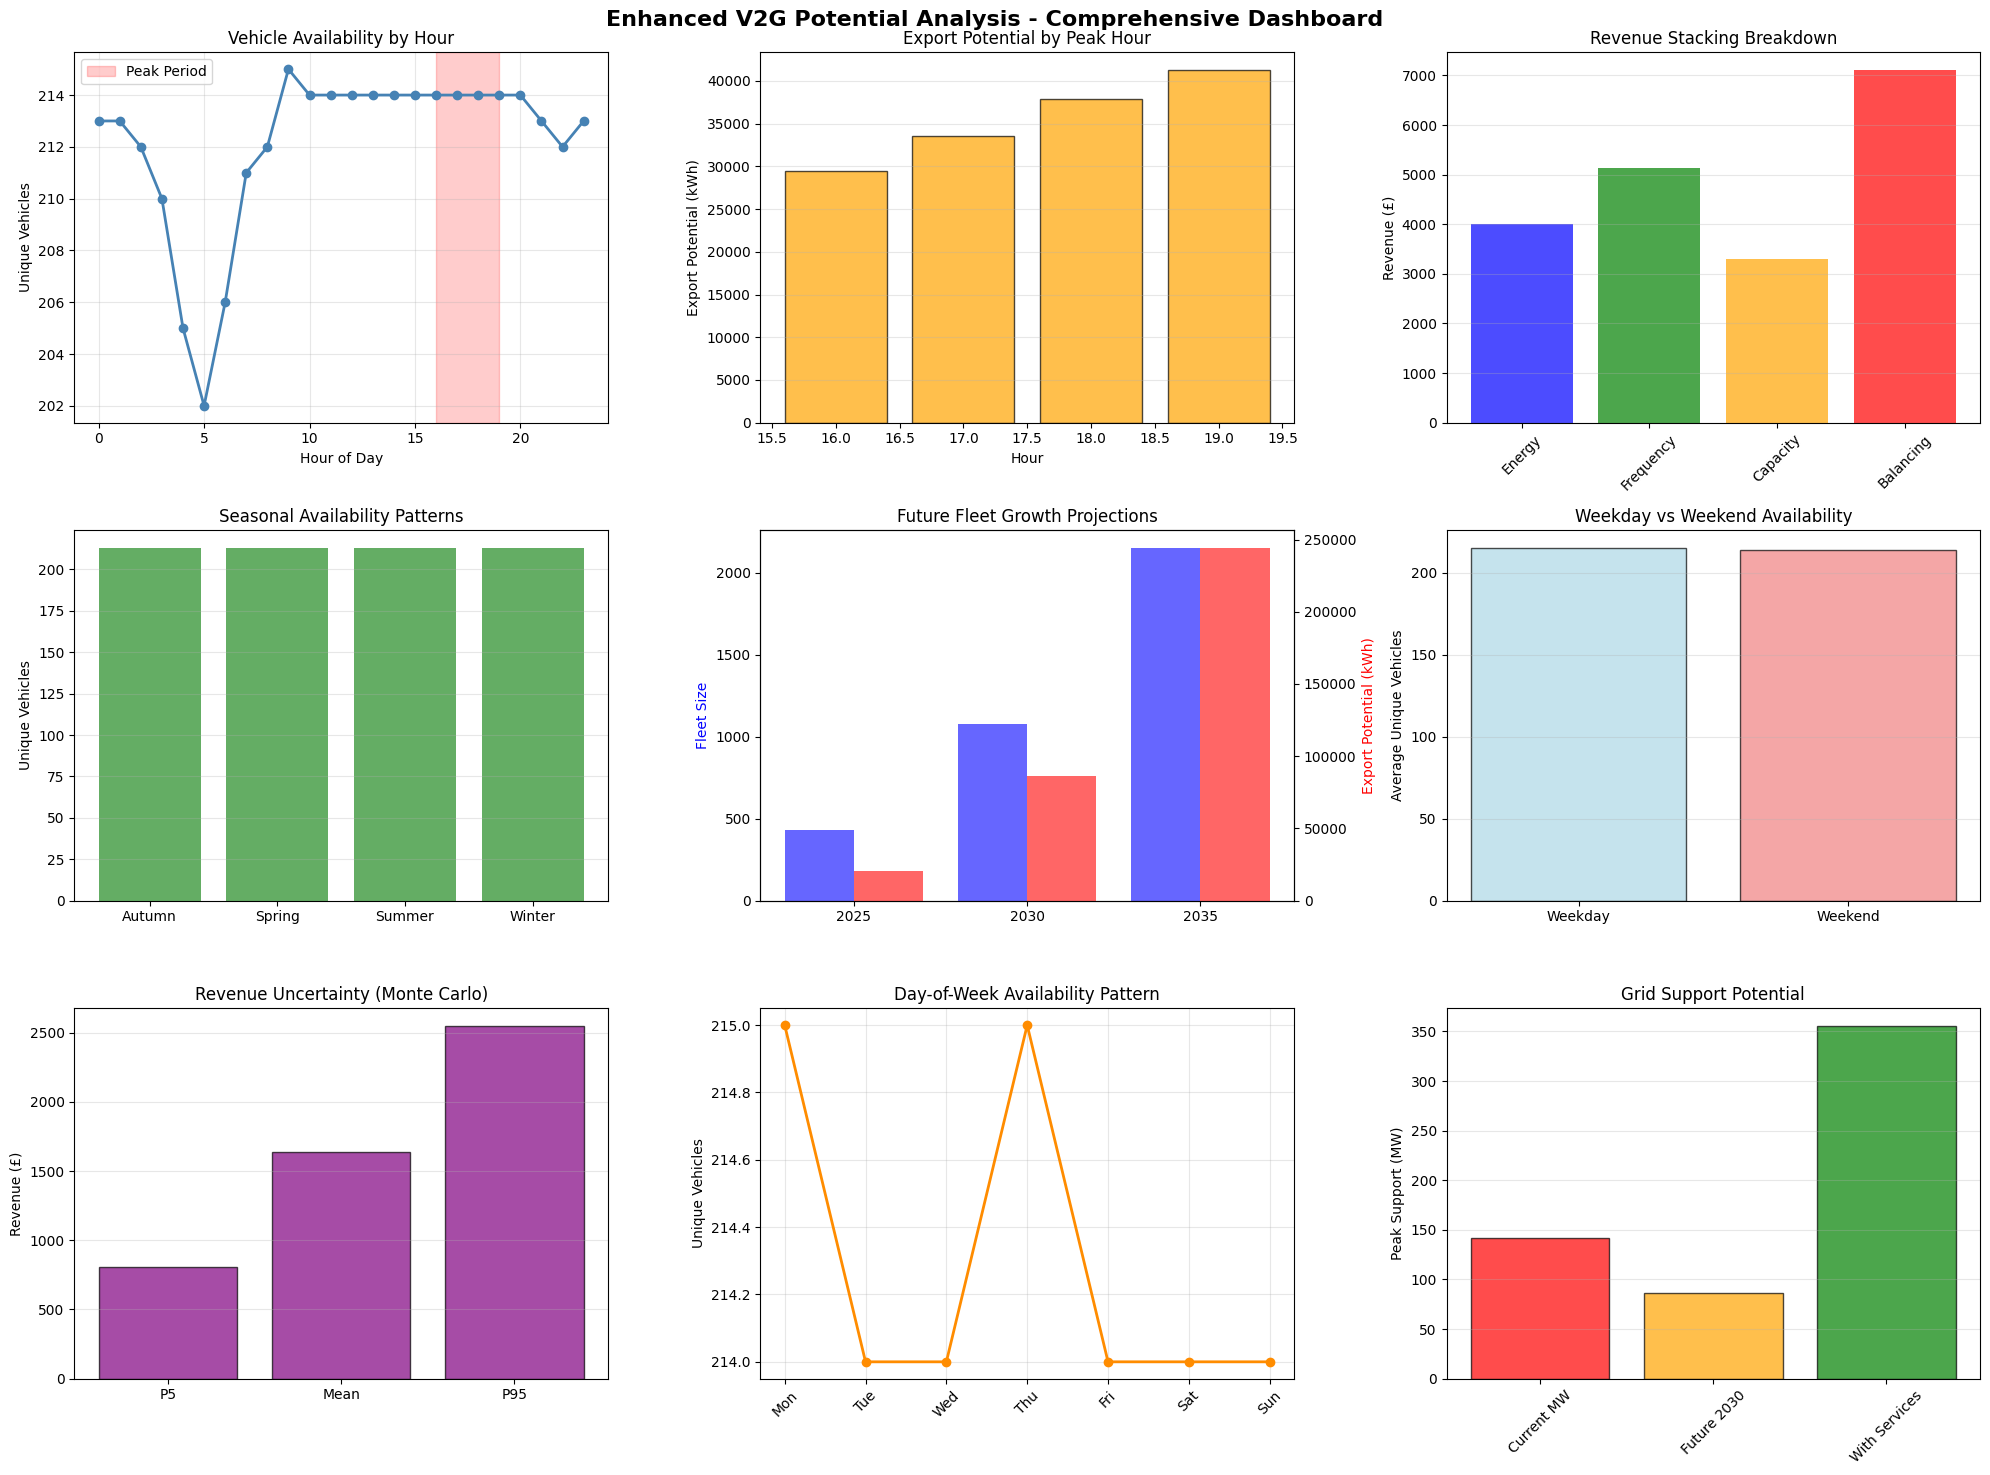

Enhanced visualizations created and saved!

Analysis completed successfully!


In [ ]:
def main():
    """Main execution function with proper error handling"""
    print("Starting Enhanced V2G Potential Analysis...")
    print("=" * 80)

    try:
        # Step 1: Load and enhance data
        sessions_df = load_and_enhance_ev_data('evchargedata.csv')
        hourly_df = expand_sessions_to_hourly_enhanced(sessions_df)

        # Step 2: Get pricing data
        pricing_data, pricing_type = get_enhanced_pricing_data()
        pricing_profile = create_pricing_profile_enhanced(pricing_data, pricing_type)

        # Step 3: Add enhanced V2G metrics
        hourly_df = add_enhanced_v2g_metrics(hourly_df)

        # Step 4: Behavioral analysis
        user_metrics, cluster_analysis = analyze_user_behavior_patterns(sessions_df)
        temporal_patterns = analyze_temporal_patterns(hourly_df)

        print("\n" + "=" * 40 + " SCENARIO ANALYSIS " + "=" * 40)

        # Step 5: Complete scenario analysis (ALL 5 scenarios)
        s1_results = scenario_1_enhanced_peak_analysis(hourly_df, pricing_profile)
        s2_results = scenario_2_enhanced_end_of_day(hourly_df, pricing_profile)
        s3_results = scenario_3_enhanced_charging_alignment(hourly_df, sessions_df, pricing_profile)
        s4_results = scenario_4_grid_services_analysis(hourly_df, pricing_profile)
        s5_results = scenario_5_future_fleet_projections(hourly_df, pricing_profile)

        # Step 6: Enhanced sensitivity analysis
        sensitivity_results, mc_summary, mc_df = enhanced_sensitivity_analysis(hourly_df, pricing_profile)

        # Step 7: Create comprehensive visualizations
        create_v2g_dashboard(temporal_patterns, s1_results, s4_results, s5_results, mc_summary)

        print("\n" + "=" * 80)
        print("Analysis completed successfully!")

        return {
            'sessions_df': sessions_df,
            'hourly_df': hourly_df,
            'temporal_patterns': temporal_patterns,
            's1_results': s1_results,
            's2_results': s2_results,
            's3_results': s3_results,
            's4_results': s4_results,
            's5_results': s5_results,
            'mc_summary': mc_summary
        }

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()
        return None

# Run the analysis
if __name__ == "__main__":
    results = main()